In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH="data/dogscats/"
sz=224

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

In [6]:
os.listdir(PATH)

['sample', 'valid', 'models', 'train', 'tmp', 'test1']

In [7]:
os.listdir(f'{PATH}valid')

['cats', 'dogs']

In [8]:
files = os.listdir(f'{PATH}valid/cats')[:5]
files

['cat.11341.jpg',
 'cat.3869.jpg',
 'cat.5089.jpg',
 'cat.7380.jpg',
 'cat.11409.jpg']

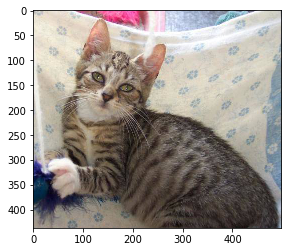

In [9]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img);

In [10]:
img.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : False
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

In [11]:
img.shape


(437, 499, 3)

In [12]:
img[:2,:5,:1]

array([[[211],
        [210],
        [208],
        [202],
        [198]],

       [[200],
        [199],
        [196],
        [193],
        [195]]], dtype=uint8)

train

In [13]:
arch = resnet34

In [14]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))

In [15]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [16]:
learn.fit(0.01, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.045839   0.033122   0.989746  
    1      0.046797   0.028044   0.98877                      



[0.0280439, 0.98876953125]

In [17]:
data.classes

['cats', 'dogs']

In [18]:
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [19]:
data.val_y.size

2000

In [20]:
log_preds = learn.predict()

In [21]:
log_preds.shape

(2000, 2)

In [22]:
log_preds[:3]

array([[-0.00007, -9.61681],
       [-0.00197, -6.22875],
       [-0.00082, -7.1112 ]], dtype=float32)

In [23]:
preds=np.argmax(log_preds, axis=1)

In [24]:
preds[:3]

array([0, 0, 0])

In [25]:
probs = np.exp(log_preds[:,1])
probs[:4]

array([0.00007, 0.00197, 0.00082, 0.00016], dtype=float32)

In [26]:
def rand_by_mask(mask):
    return np.random.choice(np.where(mask)[0], 4, replace=False)

In [27]:
?np.where

In [28]:
def rand_by_correct(is_correct):
    return rand_by_mask((preds==data.val_y)==is_correct)

In [29]:
def plot_val_with_title(idxs, title):
    imgs=np.stack([data.val_ds[x][0] for x in idxs])
    title_probs=[probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [30]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp=f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [31]:
def load_img_id(ds, idx):
    return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds, x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly satisfied


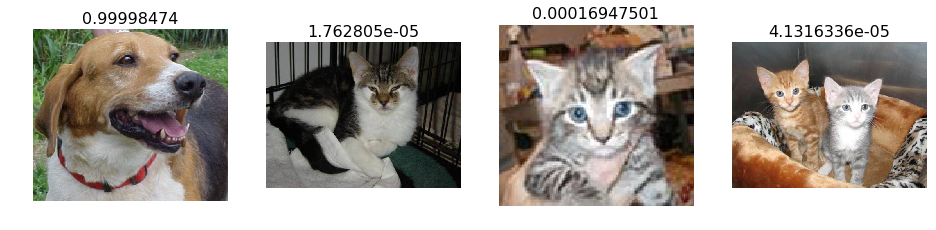

In [32]:
plot_val_with_title(rand_by_correct(True), "Correctly satisfied")

False predict


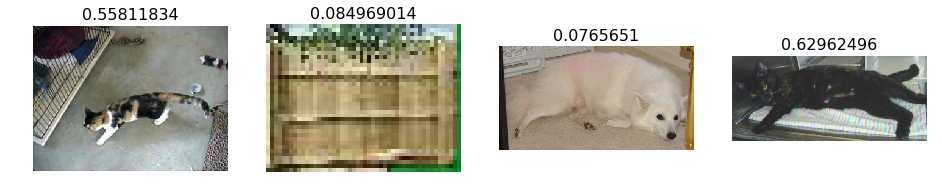

In [33]:
plot_val_with_title(rand_by_correct(False), "False predict")

In [34]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult*probs[idxs])[:4]]

def most_by_correct(y, is_correct):
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds==data.val_y)==is_correct) & (data.val_y==y), mult)


Most correct cats


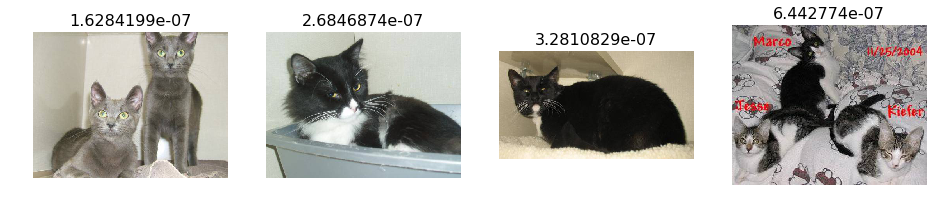

In [35]:
plot_val_with_title(most_by_correct(0,True), "Most correct cats")

Most correct dogs


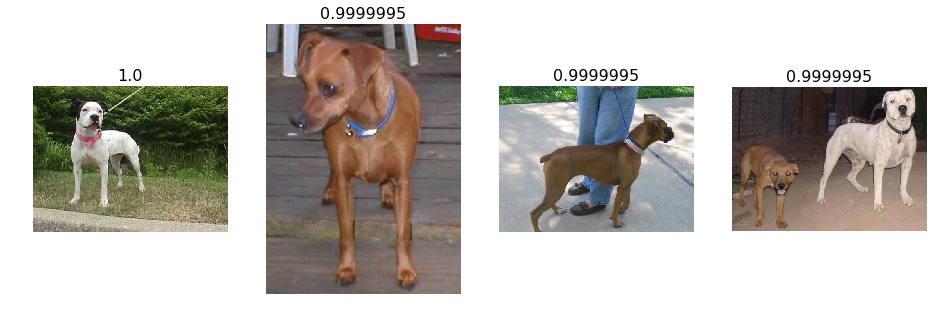

In [36]:
plot_val_with_title(most_by_correct(1,True), "Most correct dogs")

Most incorrect cats


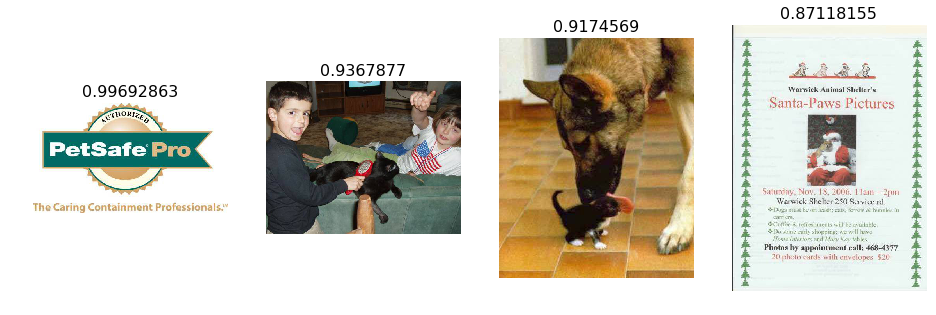

In [37]:
plot_val_with_title(most_by_correct(0,False), "Most incorrect cats")

Most incorrect dogs


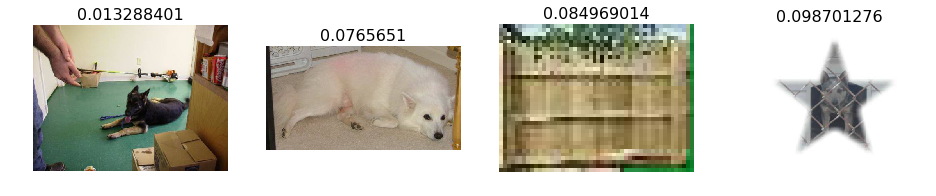

In [38]:
plot_val_with_title(most_by_correct(1,False), "Most incorrect dogs")

most uncertain


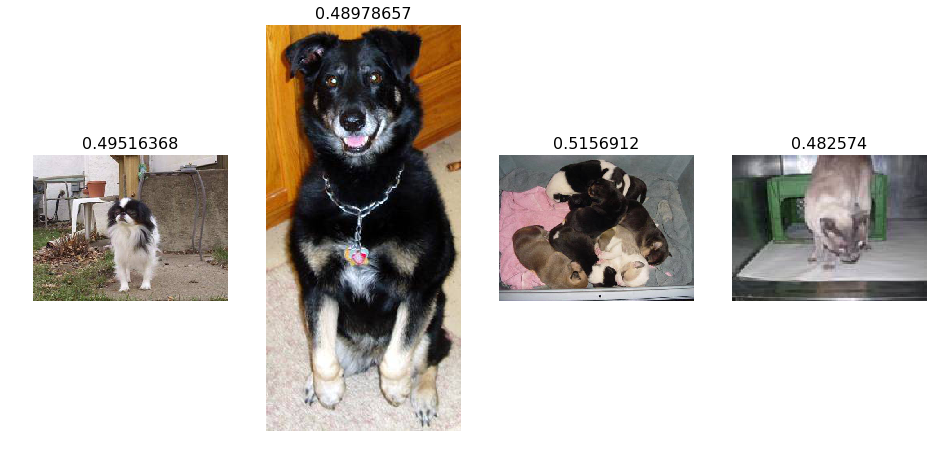

In [39]:
most_uncertain = np.argsort(np.abs(probs-0.5))[:4]
plot_val_with_title(most_uncertain, "most uncertain")

choose a learning rate

In [40]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [41]:
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 82%|████████▎ | 297/360 [00:04<00:00, 63.13it/s, loss=0.416] 


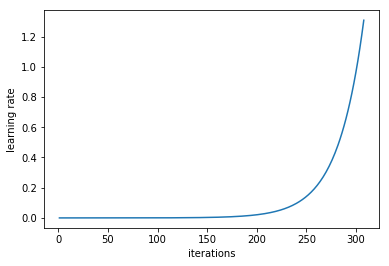

In [42]:
learn.sched.plot_lr()

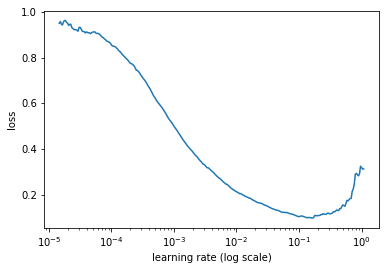

In [43]:
learn.sched.plot()

data augmentation

In [44]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)


In [45]:
def get_augs():
    data=ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [46]:
ims = np.stack([get_augs() for i in range(6)])

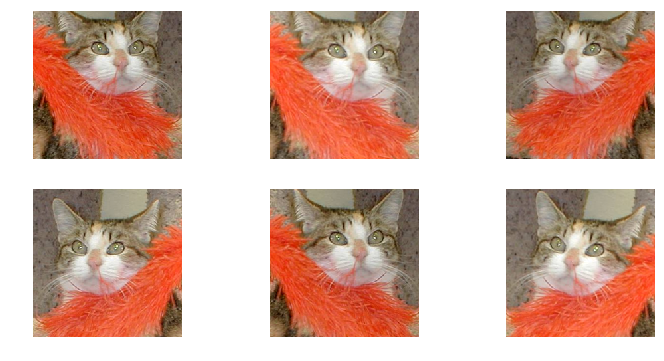

In [47]:
plots(ims, rows=2)

In [48]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [49]:
learn.fit(0.01, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.053926   0.029674   0.989746  



[0.029674148, 0.98974609375]

In [50]:
learn.precompute=False

In [51]:
learn.fit(0.01, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.046796   0.028006   0.990234  
    1      0.03702    0.027111   0.990234                     
    2      0.0402     0.025913   0.990234                     



[0.025912555, 0.990234375]

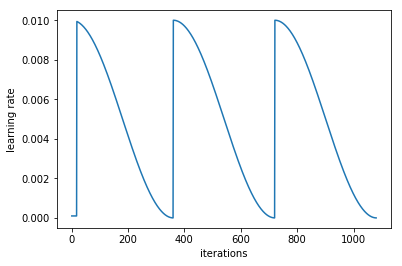

In [52]:
learn.sched.plot_lr()

In [53]:
learn.save("224_lastlayer")

In [54]:
learn.load("224_lastlayer")

In [55]:
learn.unfreeze()

early layers learning 100X small, middle layers 10X small. last layer lr_rate=0.01.

In [56]:
lr = np.array([1e-4, 1e-3, 1e-2])

In [57]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
learn.save("224_all")

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.052587   0.026351   0.990723  
    1      0.040576   0.019155   0.990723                     
    2      0.031631   0.018901   0.992676                     
    3      0.029178   0.019378   0.993164                     
    4      0.023238   0.017959   0.992676                     
    5      0.017788   0.018489   0.993164                     
    6      0.020128   0.019331   0.994629                     



[0.019330662, 0.99462890625]

In [59]:
learn.load("224_all")

In [60]:
log_preds,y = learn.TTA()

In [62]:
probs = np.mean(np.exp(log_preds),0)

In [63]:
accuracy_np(probs, y)

0.993

Confusion Matrix

In [64]:
preds = np.argmax(probs, axis=1)

In [65]:
probs = probs[:,1]

In [66]:
from sklearn.metrics import confusion_matrix

In [67]:
cm = confusion_matrix(y,preds)

[[996   4]
 [ 10 990]]


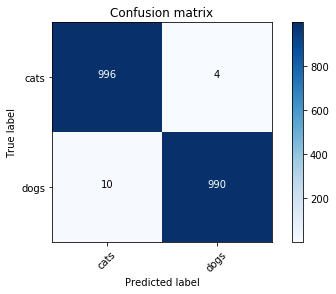

In [68]:
plot_confusion_matrix(cm, data.classes)

most incorrect cats


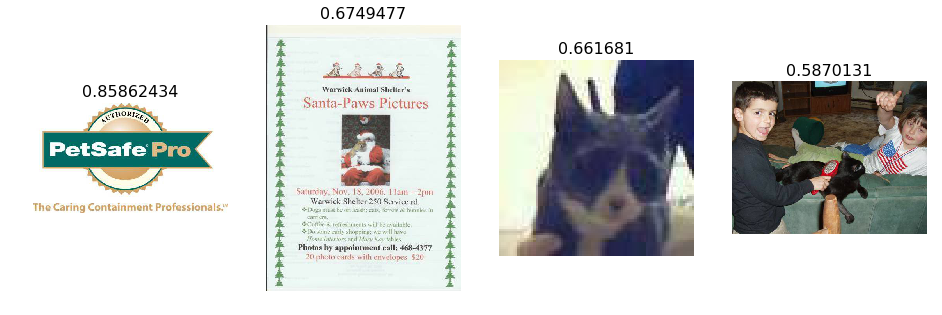

In [70]:
plot_val_with_title(most_by_correct(0,False), "most incorrect cats")


most incorrect dogs


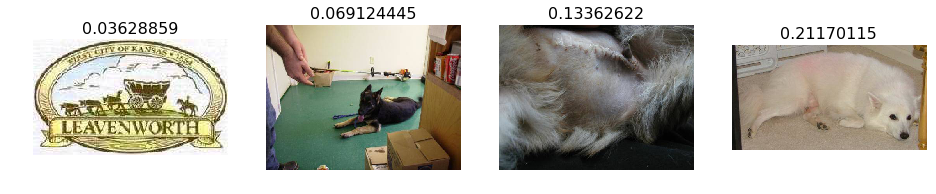

In [71]:
plot_val_with_title(most_by_correct(1,False), "most incorrect dogs")

## Review: easy steps to train a world-class image classifier
Enable data augmentation, and precompute=True  
Use lr_find() to find highest learning rate where loss is still clearly improving  
Train last layer from precomputed activations for 1-2 epochs  
Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1  
Unfreeze all layers  
Set earlier layers to 3x-10x lower learning rate than next higher layer  
Use lr_find() again  
Train full network with cycle_mult=2 until over-fitting  

In [72]:
def bi_loss(y,p):
    return np.mean(-y*np.log(p)-(1-y)*np.log(1-p))

In [74]:

acts = np.array([1, 0, 0, 1])
preds = np.array([0.9, 0.1, 0.2, 0.8])
bi_loss(acts, preds)

0.164252033486018